In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout

import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import pipeline_script
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score
import seaborn as sns
import joblib

In [2]:
patient_records = pipeline_script.gather_dict("normalized_data_20",False)
participant_df = pd.read_csv("participant_info_processed.csv",index_col="SID")

100%|██████████| 98/98 [00:15<00:00,  6.40it/s]


In [3]:
columns = [ 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI',
       'Multiple_Events', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled']
columns_participant=['AGE', 'GENDER', 'BMI','asthma',
       'body pain', 'gerd', 'hypertension', 'sleep apnea', 'arrhythmia',
       'depression', 'dyspnea', 'diabetes', 'cad', 'anxiety', 'migraine',
       'osa', 'snoring', 'difficulty breathing', 'difficulty staying asleep',
       'snort', 'rls', 'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia',
       'fatigue', 'morning headaches', 'bruxism', 'snore', 'headache']

In [4]:
rng = np.random.default_rng(seed = 40)
test_validation_indexes = rng.random(30)
a, b = 0, len(patient_records.keys())  # Example range
test_validation_indexes = np.floor(a + (b - a) * test_validation_indexes)
test_validation_indexes = [int(i) for i in test_validation_indexes]

validation_indexes = test_validation_indexes[:15]
test_indexes = test_validation_indexes[15:]
print(validation_indexes,test_indexes)

[71, 67, 92, 5, 67, 90, 46, 33, 58, 71, 11, 10, 62, 4, 4] [31, 20, 76, 78, 16, 13, 36, 51, 53, 37, 42, 35, 26, 60, 26]


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
    train_set = {}
    for i,v in tqdm(patient_records.items()):
        train_set[i] = v.loc[v["Sleep_Stage"]!="P"]
        """for column in columns_participant:
            train_set[i].loc[:,column] = participant_df.loc[i,column]"""

100%|██████████| 98/98 [00:00<00:00, 113.55it/s]


In [6]:
test_df = pd.DataFrame()
val_df = pd.DataFrame()
train_df = pd.DataFrame()

for i,key in tqdm(enumerate(list(patient_records.keys()))):
    if i in test_indexes:
        test_df= pd.concat([test_df,train_set[key]],ignore_index=True)
    elif i in validation_indexes:
        val_df= pd.concat([val_df,train_set[key]],ignore_index=True)
    else:
        train_df= pd.concat([train_df,train_set[key]],ignore_index=True)

98it [00:07, 13.47it/s]


In [7]:
X_train, y_train = train_df.drop("Sleep_Stage",axis=1),train_df["Sleep_Stage"]
X_test, y_test = test_df.drop("Sleep_Stage",axis=1),test_df["Sleep_Stage"]
X_val, y_val = val_df.drop("Sleep_Stage",axis=1),val_df["Sleep_Stage"]

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train_encoded = to_categorical(y_train_encoded, num_classes=5)
y_test_encoded = to_categorical(y_test_encoded, num_classes=5)
y_val_encoded = to_categorical(y_val_encoded, num_classes=5)

In [9]:
def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)


In [10]:
def model_mlp(X_train,y_train,X_val,y_val,activation,lr,epochs,batch_size,loss_param = 'categorical_crossentropy'):
    model = models.Sequential([
    layers.Dense(128, activation=activation),
    layers.Dense(64, activation=activation),
    layers.Dense(5, activation='softmax')  # Binary classification output
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
            loss=loss_param, 
            metrics=['accuracy'])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',       
        patience=5,               
        restore_best_weights=True 
    )

    history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_scheduler,early_stopping],
    )
    return model,history

In [11]:
def report_mlp(model,history,X_test,y_test):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    #This part reports the accuracy over the epoches, along with validation accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_title('Accuracy per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid()
    #This part calculates and reports metrics and plots the confusion matrix

    predictions = model.predict(X_test)  
    predicted_classes = np.argmax(predictions, axis=1) 
    y_test = np.argmax(y_test, axis=1) 

    cm = confusion_matrix(y_test, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform([0,1,2,3,4]), 
                yticklabels=label_encoder.inverse_transform([0,1,2,3,4]), ax=axes[1])
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    accuracy = accuracy_score(y_test, predicted_classes)
    precision = precision_score(y_test, predicted_classes,average=None)
    recall = recall_score(y_test, predicted_classes,average=None)
    f1= f1_score(y_test, predicted_classes,average=None)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {', '.join([f'{p:.2f}' for p in precision])}") 
    print(f"Recall: {', '.join([f'{r:.2f}' for r in recall])}")       
    print(f"F1-Score: {', '.join([f'{f:.2f}' for f in f1])}")        

In [17]:
model,history = model_mlp(X_train,y_train_encoded,X_val,y_val_encoded,"relu",0.005,10,16)

Epoch 1/10
345631/345631 ━━━━━━━━━━━━━━━━━━━━ 408s 1ms/step - accuracy: 0.5088 - loss: 5.9377 - val_accuracy: 0.4640 - val_loss: 1.3725 - learning_rate: 0.0045
Epoch 2/10
345631/345631 ━━━━━━━━━━━━━━━━━━━━ 391s 1ms/step - accuracy: 0.5115 - loss: 1.2701 - val_accuracy: 0.4640 - val_loss: 1.3705 - learning_rate: 0.0041
Epoch 3/10
345631/345631 ━━━━━━━━━━━━━━━━━━━━ 411s 1ms/step - accuracy: 0.5113 - loss: 1.2703 - val_accuracy: 0.4640 - val_loss: 1.3721 - learning_rate: 0.0037
Epoch 4/10
345631/345631 ━━━━━━━━━━━━━━━━━━━━ 389s 1ms/step - accuracy: 0.5117 - loss: 1.2697 - val_accuracy: 0.4640 - val_loss: 1.3693 - learning_rate: 0.0034
Epoch 5/10
345631/345631 ━━━━━━━━━━━━━━━━━━━━ 384s 1ms/step - accuracy: 0.5115 - loss: 1.2701 - val_accuracy: 0.4640 - val_loss: 1.3761 - learning_rate: 0.0030
Epoch 6/10
345631/345631 ━━━━━━━━━━━━━━━━━━━━ 405s 1ms/step - accuracy: 0.5119 - loss: 1.2695 - val_accuracy: 0.4640 - val_loss: 1.3760 - learning_rate: 0.0027
Epoch 7/10
345631/345631 ━━━━━━━━━━━━━━━

33685/33685 ━━━━━━━━━━━━━━━━━━━━ 28s 816us/step


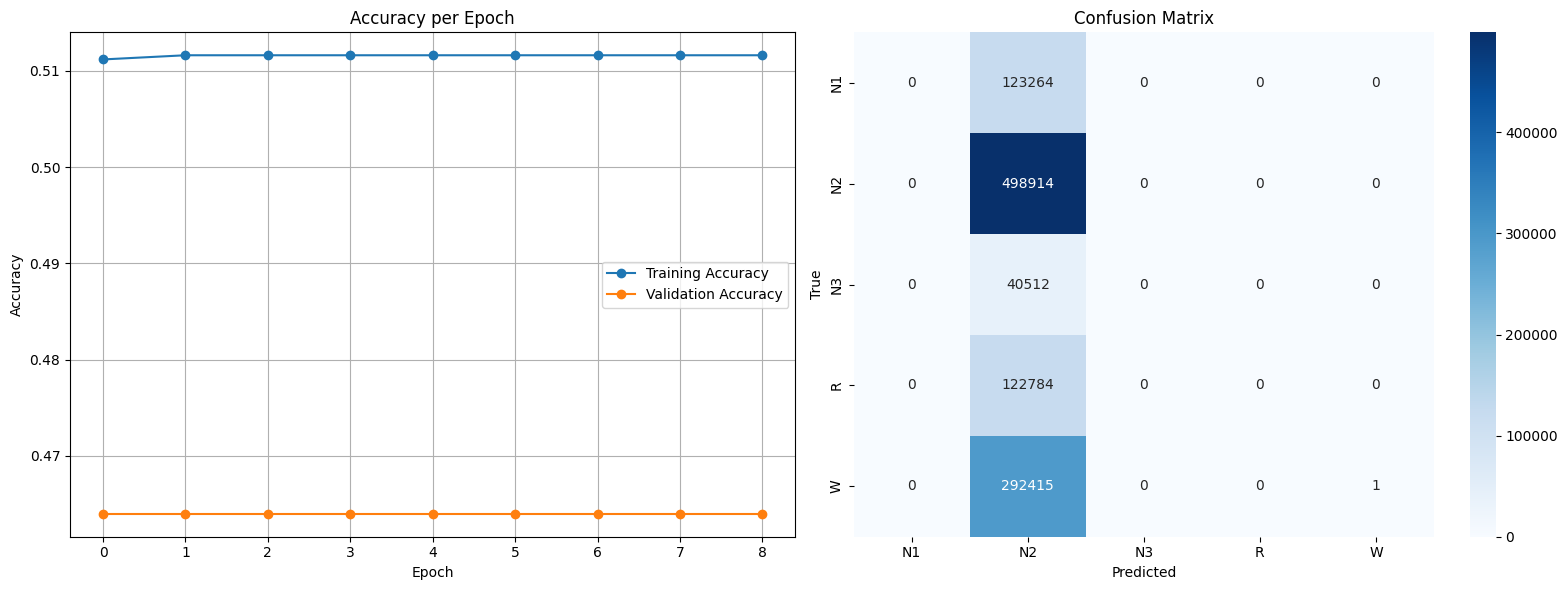

Accuracy: 0.46
Precision: 0.00, 0.46, 0.00, 0.00, 1.00
Recall: 0.00, 1.00, 0.00, 0.00, 0.00
F1-Score: 0.00, 0.63, 0.00, 0.00, 0.00


c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
report_mlp(model,history,X_test,y_test_encoded)

High Class Imbalance

In [15]:
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.
    
    Parameters:
    gamma -- focusing parameter (default=2.)
    alpha -- balancing parameter (default=0.25)
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip the predicted values to avoid NaNs using TensorFlow function
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Cross entropy loss
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Focal loss components
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=1)  # Use tf.reduce_sum instead of K.sum
        return K.sum(loss, axis=1)
    
    return focal_loss_fixed

In [104]:
np.argmax(y_train_encoded,axis=1)

array([4, 4, 4, ..., 1, 1, 1])

In [107]:
label_encoder.inverse_transform([0,1,2,3,4])

array(['N1', 'N2', 'N3', 'R', 'W'], dtype=object)

In [106]:
np.unique_counts(np.argmax(y_train_encoded,axis=1))

UniqueCountsResult(values=array([0, 1, 2, 3, 4]), counts=array([ 628034, 2829313,  156480,  573410, 1342855]))

In [47]:
np.unique_counts(y_train_encoded).counts

array([ 628034, 2829313,  156480,  573410, 1342855])

In [ ]:
model1,history1 = model_mlp(X_train,y_train_encoded,X_val,y_val_encoded,"relu",0.005,1,200,loss_param = focal_loss(gamma= 5,alpha=[1,0.1,1,1,1]))

 4184/31145 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.2418 - loss: 0.2317

KeyboardInterrupt: 

33685/33685 ━━━━━━━━━━━━━━━━━━━━ 30s 894us/step


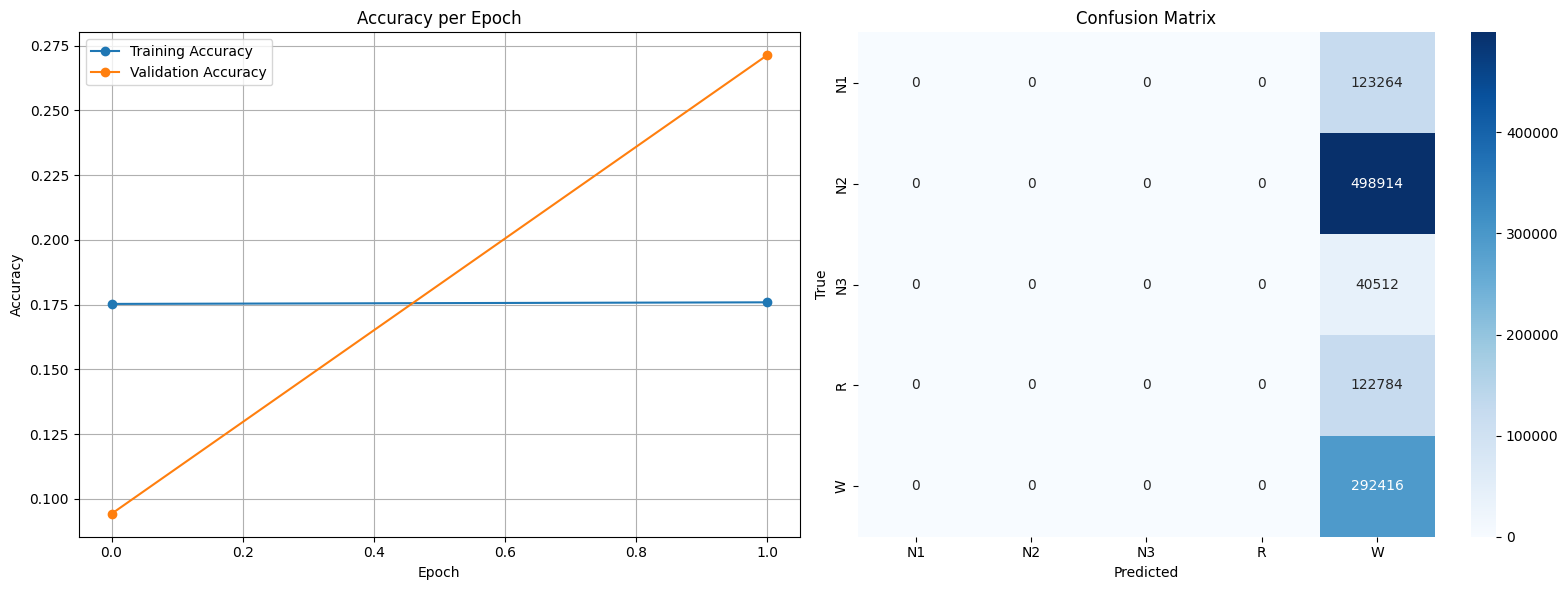

Accuracy: 0.27
Precision: 0.00, 0.00, 0.00, 0.00, 0.27
Recall: 0.00, 0.00, 0.00, 0.00, 1.00
F1-Score: 0.00, 0.00, 0.00, 0.00, 0.43


c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [115]:
report_mlp(model1,history1,X_test,y_test_encoded)

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example: If you have a binary classification problem
classes = np.unique(np.argmax(y_train_encoded, axis=1))  # y_train contains your class labels
class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train_encoded, axis=1))

# Convert to dictionary format required by Keras
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}
print(class_weight_dict)

{0: np.float64(1.7210595682483194), 1: np.float64(0.39421656520983794), 2: np.float64(6.829907894736842), 3: np.float64(1.9159582288799004), 4: np.float64(0.8237646755428009)}


In [50]:
class_weights = np.unique_counts(y_train_encoded).counts/len(y_train_encoded)
class_weights

array([0.11356665, 0.51162133, 0.02829609, 0.10368905, 0.24282688])

In [ ]:
class_weights = {0: 1.0, 1: 2.0, 2: 3.0, 3: 2.0, 4: 5.0}  # Example weights

In [12]:
X_resampled = np.load("X_resampled.npy")
y_resampled = np.load("y_resampled.npy")

In [13]:
y_resampled = to_categorical(y_resampled, num_classes=5)

In [20]:
y_resampled.shape

(7357456, 5)

In [15]:
def model_mlp(X_train,y_train,X_val,y_val,activation,lr,epochs,batch_size,loss_param = 'categorical_crossentropy'):
    model = models.Sequential([
    layers.Dense(100, activation=activation,kernel_regularizer=l2(0.1)),
    layers.Dropout(0.5),
    layers.Dense(100, activation=activation,kernel_regularizer=l1(0.1)),
    layers.Dropout(0.5),
    layers.Dense(100, activation=activation,kernel_regularizer=l2(0.1)),
    layers.Dense(100, activation=activation,kernel_regularizer=l1(0.1)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Binary classification output
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
            loss=loss_param, 
            metrics=['accuracy'])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',       
        patience=5,               
        restore_best_weights=True 
    )

    history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_scheduler,early_stopping],
    )
    return model,history

In [25]:
y_train_encoded[0]

array([0., 0., 0., 0., 1.])

In [34]:
X_train.loc[0].to_numpy()

array([ 2.93570000e+04,  9.17421094e+03,  7.18400000e+00, -2.13000000e+01,
       -6.15000000e+01,  6.30000000e+00,  3.20900000e+01,  6.58324000e-02,
        7.28500000e+01,  1.06250000e+00,  9.62207031e-01,  4.97977444e-02,
        6.54664042e+01,  0.00000000e+00,  1.03193295e+00,  1.08601670e+00,
        6.79908676e-01,  1.00000000e+00,  1.66666667e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [45]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [18]:
model1,history1 = model_mlp(X_train,y_train_encoded,X_val,y_val_encoded,"sigmoid",0.001,2,400)

Epoch 1/2
13826/13826 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.5036 - loss: 6.7406 - val_accuracy: 0.4640 - val_loss: 1.5819 - learning_rate: 9.0484e-04
Epoch 2/2
13826/13826 ━━━━━━━━━━━━━━━━━━━━ 92s 7ms/step - accuracy: 0.5115 - loss: 1.4571 - val_accuracy: 0.4640 - val_loss: 1.5624 - learning_rate: 8.1873e-04


33685/33685 ━━━━━━━━━━━━━━━━━━━━ 20s 586us/step


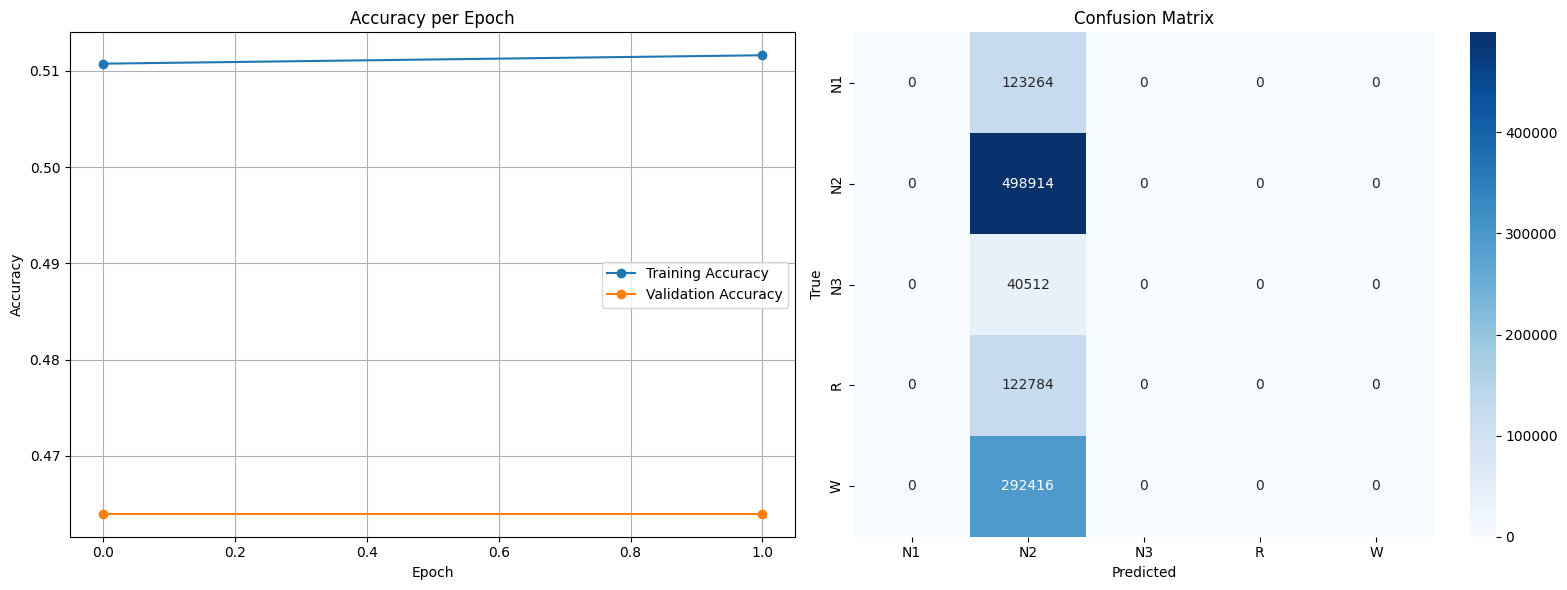

Accuracy: 0.46
Precision: 0.00, 0.46, 0.00, 0.00, 0.00
Recall: 0.00, 1.00, 0.00, 0.00, 0.00
F1-Score: 0.00, 0.63, 0.00, 0.00, 0.00


c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
report_mlp(model1,history1,X_test,y_test_encoded)

In [12]:
model2,history2 = model_mlp(X_train,y_train_encoded,X_val,y_val_encoded,"softmax",0.01,1,200)

31145/31145 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - accuracy: 0.5071 - loss: 2.3853 - val_accuracy: 0.4640 - val_loss: 2.2186 - learning_rate: 0.0090


11848/11848 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


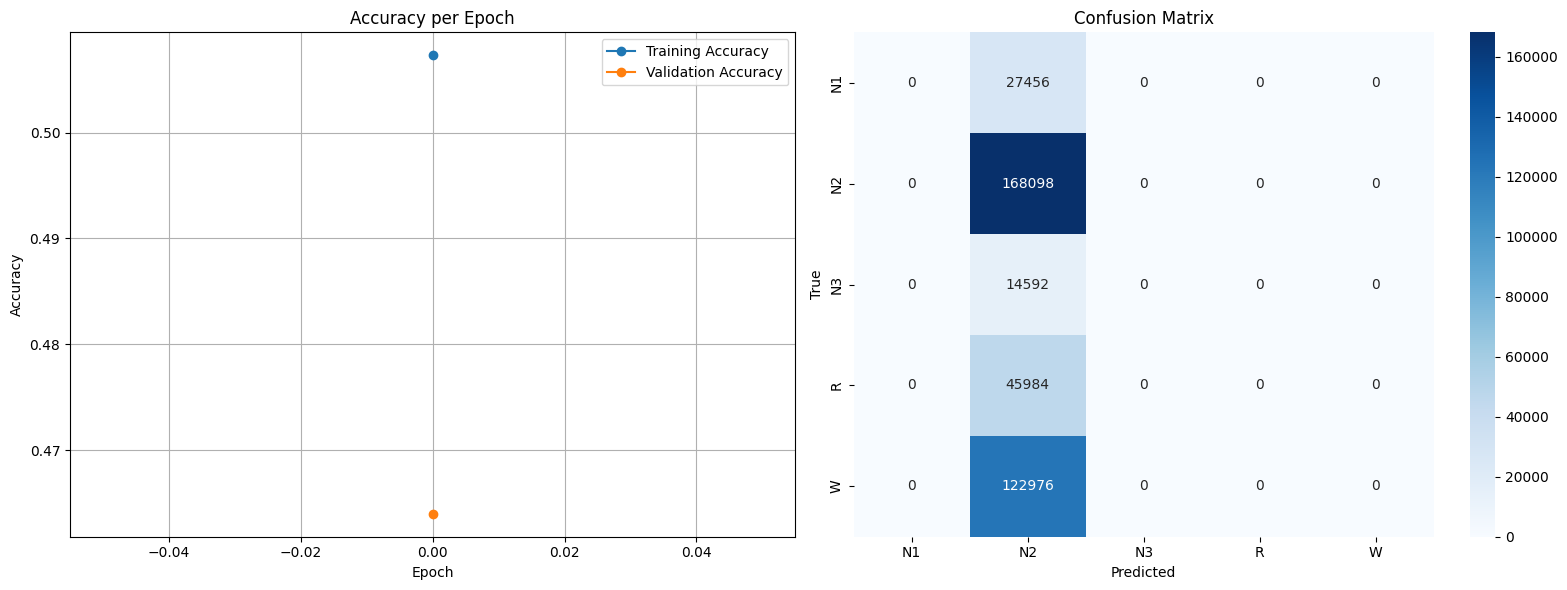

Accuracy: 0.44
Precision: 0.00, 0.44, 0.00, 0.00, 0.00
Recall: 0.00, 1.00, 0.00, 0.00, 0.00
F1-Score: 0.00, 0.61, 0.00, 0.00, 0.00


c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
report_mlp(model2,history2,X_test,y_test_encoded)

In [25]:
X_resampled[:,:20].shape

(8558900, 20)

In [33]:
model2,history2 = model_mlp(X_resampled[:,:20],y_resampled,X_val.iloc[:,:20],y_val_encoded,"relu",0.005,1,100)

85589/85589 ━━━━━━━━━━━━━━━━━━━━ 119s 1ms/step - accuracy: 0.3294 - loss: 9.3433 - val_accuracy: 0.4640 - val_loss: 1.4841 - learning_rate: 0.0045


33685/33685 ━━━━━━━━━━━━━━━━━━━━ 22s 658us/step


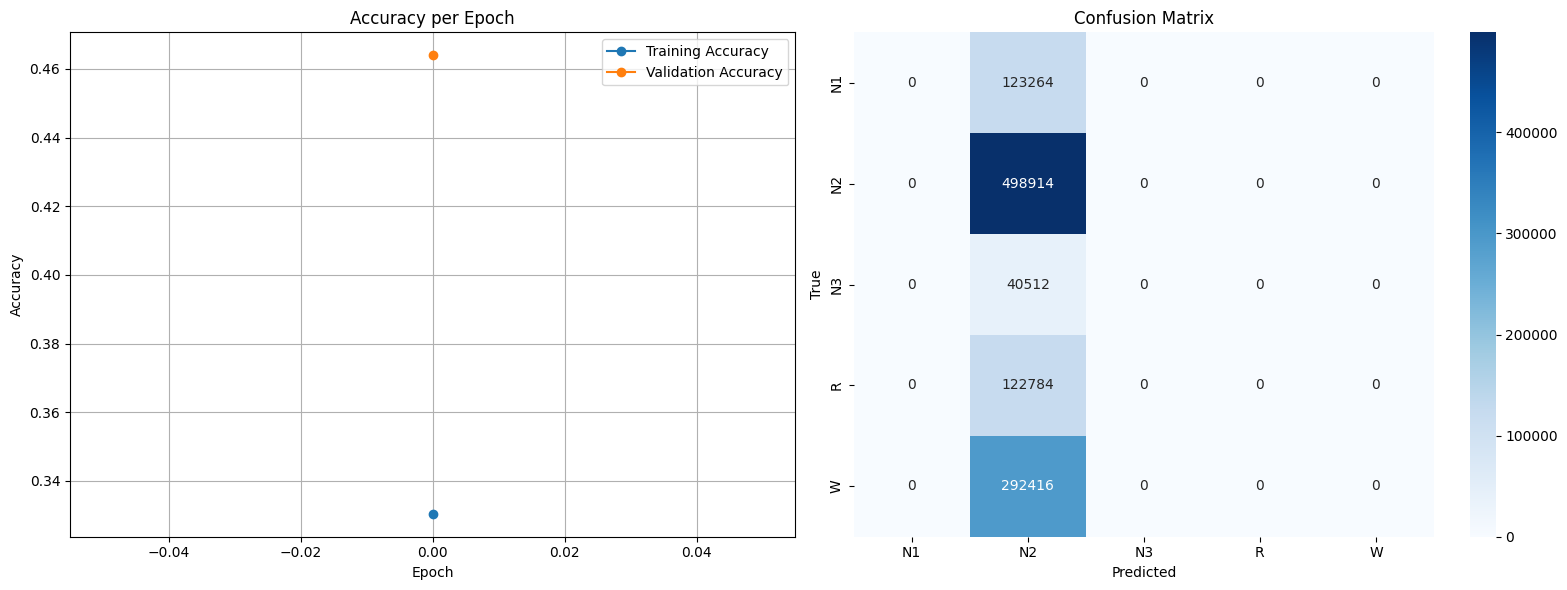

Accuracy: 0.46
Precision: 0.00, 0.46, 0.00, 0.00, 0.00
Recall: 0.00, 1.00, 0.00, 0.00, 0.00
F1-Score: 0.00, 0.63, 0.00, 0.00, 0.00


c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
report_mlp(model2,history2,X_test.iloc[:,:20],y_test_encoded)

In [38]:
model3,history3 = model_mlp(X_train.iloc[:,:20],y_train_encoded,X_val.iloc[:,:20],y_val_encoded,"relu",0.005,1,100)

55301/55301 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - accuracy: 0.5054 - loss: 10.3620 - val_accuracy: 0.4640 - val_loss: 1.3704 - learning_rate: 0.0045


33685/33685 ━━━━━━━━━━━━━━━━━━━━ 21s 629us/step


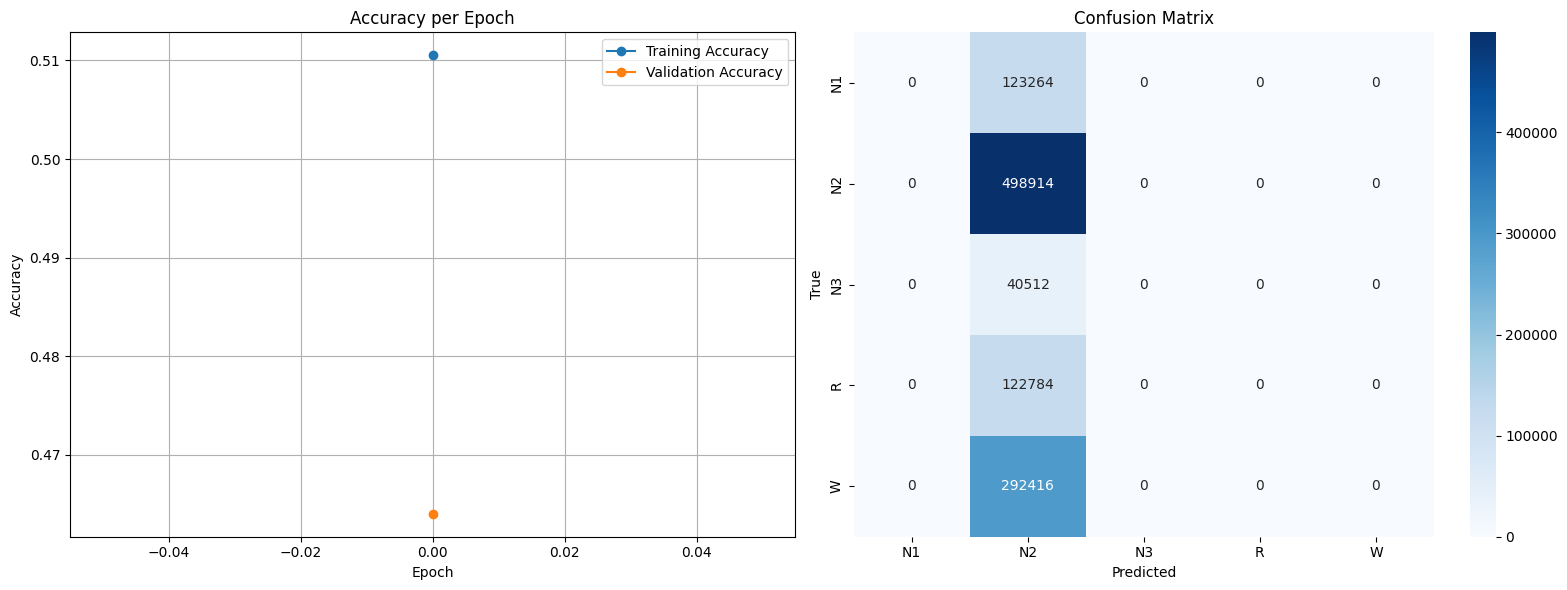

Accuracy: 0.46
Precision: 0.00, 0.46, 0.00, 0.00, 0.00
Recall: 0.00, 1.00, 0.00, 0.00, 0.00
F1-Score: 0.00, 0.63, 0.00, 0.00, 0.00


c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
report_mlp(model3,history3,X_test.iloc[:,:20],y_test_encoded)